In [1]:
!pip install hls4ml

Defaulting to user installation because normal site-packages is not writeable


In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import hls4ml
import shutil
import os

import tensorflow as tf
import keras
from keras import layers
from keras import activations
from tensorflow.keras.optimizers import Adam
from keras.layers import Conv2D, Dense, BatchNormalization, MaxPooling2D, Activation, Flatten, AveragePooling2D, MaxPool2D, Concatenate
from qkeras.qlayers import QDense, QActivation
from qkeras.qconvolutional import QConv2D
from qkeras.qpooling import QAveragePooling2D
from qkeras.quantizers import quantized_bits, quantized_relu, smooth_sigmoid

2024-02-08 23:08:55.617027: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-08 23:08:55.617080: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-08 23:08:55.618024: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-08 23:08:55.623680: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-08 23:08:56.324585: W tensorflow/compiler/tf2

WARN: Unable to import optimizer(s) from expr_templates.py: No module named 'sympy'


/home/mo623/.local/lib/python3.10/site-packages/hls4ml/converters/__init__.py:27: UserWarning: WARNING: Pytorch converter is not enabled!
  warnings.warn("WARNING: Pytorch converter is not enabled!", stacklevel=1)


In [3]:
(X_num, y_num), _ = tf.keras.datasets.mnist.load_data()
X_num = np.expand_dims(X_num, axis=-1).astype(np.float32) / 255.0

In [4]:
grid_size = 16  # image_size / mask_size

def make_numbers(X, y):
    """
    Generates a new data sample by placing random MNIST digits around a 128x128 frame

    :param X: New empty YOLO data array
    :param y: New empty YOLO labels data array
    """

    for _ in range(3): # place three digits around the image

        idx = np.random.randint(len(X_num)) # pick a random digit to insert in frame
        number = X_num[idx] # grab digit
        kls = y_num[idx]    # grab class

        px, py = np.random.randint(0, 100), np.random.randint(0, 100) # generate a random position for the digit

        # digit belong which mask position
        mx, my = (px+14) // grid_size, (py+14) // grid_size # calculate which mask region the digit will beglong to
        channels = y[my][mx]

        # prevent duplicates
        if channels[0] > 0:
            continue

        channels[0] = 1.0
        channels[1] = px - (mx * grid_size)  # x1
        channels[2] = py - (my * grid_size)  # y1
        channels[3] = 28.0                   # x2
        channels[4] = 28.0                   # y2
        channels[5 + kls] = 1.0

        # Insert digit to frame
        X[py:py+28, px:px+28] += number

def make_data(size=64):
    """
    Generates a new dataset for YOLO training

    :param size: Number of samples to generate for training, can be larger than MNIST dataset
    :return: New dataset and labels
    """

    X = np.zeros((size, 128, 128, 1), dtype=np.float32) # New data sample of 128x128
    y = np.zeros((size, 8, 8, 15), dtype=np.float32)    # New data output consists of probability, bounding box, and class

    # Generate data
    for i in range(size):
        make_numbers(X[i], y[i])

    X = np.clip(X, 0.0, 1.0)
    return X, y

def show_predict(X, y, threshold=0.1):
    """
    Display single prediction results

    :param X: Data sample input
    :param y: Model predictions
    :param threshold: Probability threshold
    """

    X = X.copy()
    for mx in range(8):
        for my in range(8):
            channels = y[my][mx]
            prob, x1, y1, x2, y2 = channels[:5]

            # if prob < threshold we won't show any thing
            if prob < threshold:
                continue

            color = 255
            # bounding box
            px, py = (mx * grid_size) + x1, (my * grid_size) + y1
            cv2.rectangle(X, (int(px), int(py)), (int(px + x2), int(py + y2)), -1, 1)

            # label
            cv2.rectangle(X, (int(px), int(py - 10)), (int(px + 12), int(py)), -1, -1)
            kls = np.argmax(channels[5:])
            cv2.putText(X, f'{kls}', (int(px + 2), int(py-2)), cv2.FONT_HERSHEY_PLAIN, 0.7, (0.0, 0.0, 0.0))

            print("digit: " + str(np.argmax(channels[5:15])) + ", prob: " + str(prob) + ", x1: " + str(int(px)) + ", y1: " + str(int(py)) + ", x2: " + str(int(px + x2)) + ", y2: " + str(int(py + y2)))

    plt.imshow(X, cmap="gray")

digit: 3, prob: 1.0, x1: 18, y1: 66, x2: 46, y2: 94
digit: 9, prob: 1.0, x1: 55, y1: 78, x2: 83, y2: 106
digit: 0, prob: 1.0, x1: 88, y1: 97, x2: 116, y2: 125


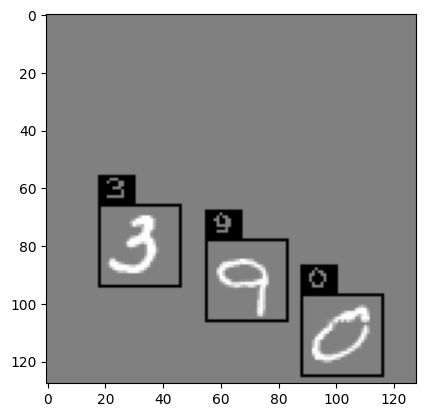

In [5]:
X, y = make_data(size=1)
show_predict(X[0], y[0])

In [6]:
idx_p = [0] # probability
idx_bb = [1, 2, 3, 4] # bounding box
idx_cls = [5, 6, 7, 8, 9, 10, 11, 12, 13, 14] # class

@tf.function
def loss_bb(y_true, y_pred):
    y_true = tf.gather(y_true, idx_bb, axis=-1)
    y_pred = tf.gather(y_pred, idx_bb, axis=-1)

    loss = tf.keras.losses.mean_squared_error(y_true, y_pred)
    return tf.reduce_mean(loss[loss > 0.0])

@tf.function
def loss_p(y_true, y_pred):
    y_true = tf.gather(y_true, idx_p, axis=-1)
    y_pred = tf.gather(y_pred, idx_p, axis=-1)

    loss = tf.losses.binary_crossentropy(y_true, y_pred)
    return tf.reduce_sum(loss)

@tf.function
def loss_cls(y_true, y_pred):
    y_true = tf.gather(y_true, idx_cls, axis=-1)
    y_pred = tf.gather(y_pred, idx_cls, axis=-1)

    loss = tf.losses.binary_crossentropy(y_true, y_pred)
    return tf.reduce_sum(loss)

@tf.function
def loss_func(y_true, y_pred):
    return loss_bb(y_true, y_pred) + loss_p(y_true, y_pred) + loss_cls(y_true, y_pred)

opt = tf.keras.optimizers.Adam(learning_rate=0.003)

2024-02-08 23:08:57.904177: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [7]:
def baby_YOLO_conv():
    """
    Baby YOLO model architecture

    :return: Keras model
    """

    tf.compat.v1.reset_default_graph()
    x = inputs = keras.Input(shape=(128, 128, 1), name='input_1')

    x = QConv2D(16, kernel_size=3, padding='same', kernel_quantizer=quantized_bits(15,3,alpha=1), bias_quantizer=quantized_bits(7,0,alpha=1), kernel_initializer='lecun_uniform')(x)
    x = QActivation(activation=quantized_relu(16,8))(x)
    x = MaxPool2D()(x)
    x = BatchNormalization()(x) # size: 64x64

    x = QConv2D(16, kernel_size=3, padding='same', kernel_quantizer=quantized_bits(16,2,alpha=1), bias_quantizer=quantized_bits(7,2,alpha=1), kernel_initializer='lecun_uniform')(x)
    x = QActivation(activation=quantized_relu(16,8))(x)
    x = MaxPool2D()(x)
    x = BatchNormalization()(x)  # size: 64x64

    x = QConv2D(16, kernel_size=3, padding='same', kernel_quantizer=quantized_bits(16,3,alpha=1), bias_quantizer=quantized_bits(8,2,alpha=1), kernel_initializer='lecun_uniform')(x)
    x = QActivation(activation=quantized_relu(16,8))(x)
    x = MaxPool2D()(x)
    x = BatchNormalization()(x)  # size: 32x32

    x = QConv2D(16, kernel_size=3, padding='same', kernel_quantizer=quantized_bits(16,2,alpha=1), bias_quantizer=quantized_bits(10,2,alpha=1), kernel_initializer='lecun_uniform')(x)
    x = QActivation(activation=quantized_relu(16,8))(x)
    x = MaxPool2D()(x)
    x = BatchNormalization()(x)  # size: 16x16

    x_prob = QConv2D(1, kernel_size=3, padding='same', name='x_prob', activation='sigmoid', kernel_quantizer=quantized_bits(11,2,alpha=1), bias_quantizer=quantized_bits(2,1,alpha=1), kernel_initializer='lecun_uniform')(x)
    x_boxes = QConv2D(4, kernel_size=3, padding='same', name='x_boxes', kernel_quantizer=quantized_bits(17,3,alpha=1), bias_quantizer=quantized_bits(4,3,alpha=1), kernel_initializer='lecun_uniform')(x)
    x_cls = QConv2D(10, kernel_size=3, padding='same', name='x_cls', activation='sigmoid', kernel_quantizer=quantized_bits(20,2,alpha=1), bias_quantizer=quantized_bits(8,1,alpha=1), kernel_initializer='lecun_uniform')(x)

    gate = tf.where(x_prob > 0.5, tf.ones_like(x_prob), tf.zeros_like(x_prob))
    x_boxes = x_boxes * gate
    x_cls = x_cls * gate

    x = Concatenate()([x_prob, x_boxes])
    x = Concatenate()([x, x_cls])

    model = tf.keras.models.Model(inputs, x)
    return model

In [8]:
model = baby_YOLO_conv()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 1)]        0         []                            
                                                                                                  
 q_conv2d (QConv2D)          (None, 128, 128, 16)         160       ['input_1[0][0]']             
                                                                                                  
 q_activation (QActivation)  (None, 128, 128, 16)         0         ['q_conv2d[0][0]']            
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 64, 64, 16)           0         ['q_activation[0][0]']        
 D)                                                                                           

In [9]:
model.compile(loss=loss_func, optimizer=opt)

In [10]:
batch_size = 32
X_train, y_train = make_data(size=batch_size * 400)
model.fit(X_train, y_train, batch_size=batch_size, epochs=30, shuffle=True)

Epoch 1/30
400/400 [==============================] - 35s 81ms/step - loss: 278.8725
Epoch 2/30
400/400 [==============================] - 33s 82ms/step - loss: 120.5338
Epoch 3/30
400/400 [==============================] - 33s 82ms/step - loss: 105.7590
Epoch 4/30
400/400 [==============================] - 34s 84ms/step - loss: 94.7849
Epoch 5/30
400/400 [==============================] - 33s 83ms/step - loss: 89.7018
Epoch 6/30
400/400 [==============================] - 33s 83ms/step - loss: 84.4192
Epoch 7/30
400/400 [==============================] - 33s 82ms/step - loss: 80.2943
Epoch 8/30
400/400 [==============================] - 33s 82ms/step - loss: 76.6095
Epoch 9/30
400/400 [==============================] - 33s 83ms/step - loss: 74.3181
Epoch 10/30
400/400 [==============================] - 34s 84ms/step - loss: 72.7497
Epoch 11/30
400/400 [==============================] - 33s 82ms/step - loss: 70.2090
Epoch 12/30
400/400 [==============================] - 34s 84ms/step - 

In [14]:
class KReduce(tf.keras.layers.Layer):
    '''Keras implementation of custom layer'''

    def __init__(self):
        super().__init__()

    def call(self, inputs):
        # inputs: a tensor of shape(8,8,15)
        return inputs[:, :, :, 0] # We want our hardware model output to be of shape (1,8,8,1)

class HReduce(hls4ml.model.layers.Layer):
    '''hls4ml implementation of custom layer'''

    def initialize(self):
        inp = self.get_input_variable()
        shape = list(inp.shape)
        shape[-1] = 1 # new output shape is (1,8,8,1)

        dims = ['OUT_HEIGHT_{}'.format(self.index), 'OUT_WIDTH_{}'.format(self.index), 'N_FILT_{}'.format(self.index)]

        self.add_output_variable(shape, dims)

def parse_reduce_layer(keras_layer, input_names, input_shapes, data_reader):
    '''Parser for converter'''

    layer = {}
    layer['class_name'] = 'HReduce'
    #layer['name'] = keras_layer['config']['name']
    layer['name'] = 'quantized_relu'
    layer['n_in'] = input_shapes[0][1]*input_shapes[0][2]
    layer['grid_size'] = grid_size
    outshape = [[None, 8, 8]]

    if input_names is not None:
        layer['inputs'] = input_names

    return layer, outshape

# HLS model layer configuration
red_config_template = """struct config{index} : nnet::reduce_config {{
    static const unsigned n_in = {n_in};
    static const unsigned grid_size = {grid_size};
}};\n"""

red_function_template ='nnet::reduce<{input_t}, {output_t}, {config}>({input}, {output});'
red_include_list = ['nnet_utils/nnet_reduce.h']

class HReduceConfigTemplate(hls4ml.backends.template.LayerConfigTemplate):
    def __init__(self):
        super().__init__(HReduce)
        self.template = red_config_template

    def format(self, node):
        params = self._default_config_params(node)
        return self.template.format(**params)

class HReduceFunctionTemplate(hls4ml.backends.template.FunctionCallTemplate):
    '''New layer function template'''

    def __init__(self):
        super().__init__(HReduce, include_header=red_include_list)
        self.template = red_function_template

    def format(self, node):
        params = self._default_function_params(node)
        return self.template.format(**params)

# Register the converter for custom Keras layer
hls4ml.converters.register_keras_layer_handler('KReduce', parse_reduce_layer)

# Register the hls4ml's IR layer
hls4ml.model.layers.register_layer('HReduce', HReduce)

for backend_id in ['Vivado']:
    # Register the optimization passes (if any)
    backend = hls4ml.backends.get_backend(backend_id)

    # Register template passes for the given backend
    backend.register_template(HReduceConfigTemplate)
    backend.register_template(HReduceFunctionTemplate)

    # Register HLS implementation
    backend.register_source(os.path.abspath("/content/drive/MyDrive/nnet_reduce.h"))

Exception: Layer KReduce already registered

In [15]:
# class quantized_relu(quantized_relu):
#     ''' Workaround for quantized_relu __name__ not found bug '''
#     def __init__(self, W, I):
#         super(quantized_relu, self).__init__(W, I)
#         self.__name__ = 'quantized_relu'

def baby_YOLO_conv_reduce():
    """
    Baby YOLO model architecture with new custom layer

    :return: Keras model
    """

    tf.compat.v1.reset_default_graph()
    x = inputs = keras.Input(shape=(128, 128, 1), name='input_1')

    x = QConv2D(16, kernel_size=3, padding='same', kernel_quantizer=quantized_bits(15,3,alpha=1), bias_quantizer=quantized_bits(7,0,alpha=1), kernel_initializer='lecun_uniform')(x)
    x = QActivation(activation=quantized_relu(16,8))(x)
    x = MaxPool2D()(x)
    x = BatchNormalization()(x) # size: 64x64

    x = QConv2D(16, kernel_size=3, padding='same', kernel_quantizer=quantized_bits(16,2,alpha=1), bias_quantizer=quantized_bits(7,2,alpha=1), kernel_initializer='lecun_uniform')(x)
    x = QActivation(activation=quantized_relu(16,8))(x)
    x = MaxPool2D()(x)
    x = BatchNormalization()(x)  # size: 64x64

    x = QConv2D(16, kernel_size=3, padding='same', kernel_quantizer=quantized_bits(16,3,alpha=1), bias_quantizer=quantized_bits(8,2,alpha=1), kernel_initializer='lecun_uniform')(x)
    x = QActivation(activation=quantized_relu(16,8))(x)
    x = MaxPool2D()(x)
    x = BatchNormalization()(x)  # size: 32x32

    x = QConv2D(16, kernel_size=3, padding='same', kernel_quantizer=quantized_bits(16,2,alpha=1), bias_quantizer=quantized_bits(10,2,alpha=1), kernel_initializer='lecun_uniform')(x)
    x = QActivation(activation=quantized_relu(16,8))(x)
    x = MaxPool2D()(x)
    x = BatchNormalization()(x)  # size: 16x16

    x_prob = QConv2D(1, kernel_size=3, padding='same', name='x_prob', activation='sigmoid', kernel_quantizer=quantized_bits(11,2,alpha=1), bias_quantizer=quantized_bits(2,1,alpha=1), kernel_initializer='lecun_uniform')(x)
    x_boxes = QConv2D(4, kernel_size=3, padding='same', name='x_boxes', kernel_quantizer=quantized_bits(17,3,alpha=1), bias_quantizer=quantized_bits(4,3,alpha=1), kernel_initializer='lecun_uniform')(x)
    x_cls = QConv2D(10, kernel_size=3, padding='same', name='x_cls', activation='sigmoid', kernel_quantizer=quantized_bits(20,2,alpha=1), bias_quantizer=quantized_bits(8,1,alpha=1), kernel_initializer='lecun_uniform')(x)

    x = Concatenate()([x_prob, x_boxes])
    x = Concatenate()([x, x_cls])

    #x = KReduce()(x)

    model = tf.keras.models.Model(inputs, x)
    return model

model_reduce = baby_YOLO_conv_reduce()
model_reduce.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 1)]        0         []                            
                                                                                                  
 q_conv2d (QConv2D)          (None, 128, 128, 16)         160       ['input_1[0][0]']             
                                                                                                  
 q_activation (QActivation)  (None, 128, 128, 16)         0         ['q_conv2d[0][0]']            
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 64, 64, 16)           0         ['q_activation[0][0]']        
 D)                                                                                           

In [17]:
tf.keras.utils.plot_model(model_reduce)

AttributeError: module 'pydot' has no attribute 'InvocationException'

In [18]:
def print_dict(d, indent=0):
    """
    Prints dictionary to view hls4ml model config

    :return: Keras model
    """

    align = 20
    for key, value in d.items():
        print('  ' * indent + str(key), end='')
        if isinstance(value, dict):
            print()
            print_dict(value, indent+1)
        else:
            print(':' + ' ' * (20 - len(key) - 2 * indent) + str(value))

In [19]:
config = hls4ml.utils.config_from_keras_model (model_reduce,
                                                   default_precision = 'ap_fixed<16,8>',
                                                   granularity = 'name')

strategy = "Latency"
rf = 1
tracing = True
OUT_DIR = f'yolo_on_frame_grabber'

config["Model"]["Trace"] = tracing

config["Model"]["Strategy"] = "Resource"
for layer in config["LayerName"]:
    config["LayerName"][layer]["Trace"] = tracing
    config["LayerName"][layer]['ReuseFactor'] = rf
    config["LayerName"][layer]["Strategy"] = strategy

config["LayerName"]["q_conv2d"]['ReuseFactor'] = 1
config["LayerName"]["q_conv2d"]["Strategy"] = "Latency"
config["LayerName"]["q_conv2d"]["Precision"]["weight"] = "ap_fixed<15,3>"
config["LayerName"]["q_conv2d"]["Precision"]["bias"] = "ap_fixed<7,0>"

# config["LayerName"]["batch_normalization"]["Precision"]["scale"] = "ap_fixed<7,7>"
# config["LayerName"]["batch_normalization"]["Precision"]["bias"] = "ap_fixed<9,3>"

config["LayerName"]["q_conv2d_1"]['ReuseFactor'] = 4
config["LayerName"]["q_conv2d_1"]["Strategy"] = "Latency"
config["LayerName"]["q_conv2d_1"]["Precision"]["weight"] = "ap_fixed<16,2>"
config["LayerName"]["q_conv2d_1"]["Precision"]["bias"] = "ap_fixed<7,2>"

# config["LayerName"]["batch_normalization_1"]["Precision"]["scale"] = "ap_fixed<6,3>"
# config["LayerName"]["batch_normalization_1"]["Precision"]["bias"] = "ap_fixed<8,3>"

config["LayerName"]["q_conv2d_2"]['ReuseFactor'] = 12
config["LayerName"]["q_conv2d_2"]["Strategy"] = "Resource"
config["LayerName"]["q_conv2d_2"]["Precision"]["weight"] = "ap_fixed<16,3>"
config["LayerName"]["q_conv2d_2"]["Precision"]["bias"] = "ap_fixed<8,2>"

# config["LayerName"]["batch_normalization_2"]["Precision"]["scale"] = "ap_fixed<4,1>"
# config["LayerName"]["batch_normalization_2"]["Precision"]["bias"] = "ap_fixed<7,3>"

config["LayerName"]["q_conv2d_3"]['ReuseFactor'] = 48
config["LayerName"]["q_conv2d_3"]["Strategy"] = "Resource"
config["LayerName"]["q_conv2d_3"]["Precision"]["weight"] = "ap_fixed<16,2>"
config["LayerName"]["q_conv2d_3"]["Precision"]["bias"] = "ap_fixed<10,2>"

# config["LayerName"]["batch_normalization_3"]["Precision"]["scale"] = "ap_fixed<5,1>"
# config["LayerName"]["batch_normalization_3"]["Precision"]["bias"] = "ap_fixed<9,4>"

config["LayerName"]["x_prob"]['ReuseFactor'] = 48
config["LayerName"]["x_prob"]["Precision"]["weight"] = "ap_fixed<11,2>"
config["LayerName"]["x_prob"]["Precision"]["bias"] = "ap_fixed<2,1>"

config["LayerName"]["x_boxes"]['ReuseFactor'] = 48
config["LayerName"]["x_boxes"]["Precision"]["weight"] = "ap_fixed<17,3>"
config["LayerName"]["x_boxes"]["Precision"]["bias"] = "ap_fixed<4,3>"

config["LayerName"]["x_cls"]['ReuseFactor'] = 48
config["LayerName"]["x_cls"]["Precision"]["weight"] = "ap_fixed<20,2>"
config["LayerName"]["x_cls"]["Precision"]["bias"] = "ap_fixed<8,1>"

config["LayerName"]["k_reduce"]["Precision"]["result"] = "ap_uint<33>"

print_dict(config)

hls_model = hls4ml.converters.convert_from_keras_model(model_reduce,
                                                       hls_config = config,
                                                       io_type = 'io_stream',
                                                       output_dir = OUT_DIR,
                                                       part='xcku035-fbva676-2-e'
                                                       )

hls_model.compile()

Interpreting Model
Topology:
Layer name: input_1, layer type: InputLayer, input shapes: [[None, 128, 128, 1]], output shape: [None, 128, 128, 1]
Layer name: q_conv2d, layer type: QConv2D, input shapes: [[None, 128, 128, 1]], output shape: [None, 128, 128, 16]
Layer name: q_activation, layer type: Activation, input shapes: [[None, 128, 128, 16]], output shape: [None, 128, 128, 16]
Layer name: max_pooling2d, layer type: MaxPooling2D, input shapes: [[None, 128, 128, 16]], output shape: [None, 64, 64, 16]
Layer name: batch_normalization, layer type: BatchNormalization, input shapes: [[None, 64, 64, 16]], output shape: [None, 64, 64, 16]
Layer name: q_conv2d_1, layer type: QConv2D, input shapes: [[None, 64, 64, 16]], output shape: [None, 64, 64, 16]
Layer name: q_activation_1, layer type: Activation, input shapes: [[None, 64, 64, 16]], output shape: [None, 64, 64, 16]
Layer name: max_pooling2d_1, layer type: MaxPooling2D, input shapes: [[None, 64, 64, 16]], output shape: [None, 32, 32, 16]


/home/mo623/.local/lib/python3.10/site-packages/keras/src/constraints.py:365: UserWarning: The `keras.constraints.serialize()` API should only be used for objects of type `keras.constraints.Constraint`. Found an instance of type <class 'qkeras.quantizers.quantized_bits'>, which may lead to improper serialization.
  warnings.warn(


KeyError: 'k_reduce'